In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/item_data.csv
/kaggle/input/coupon_item_mapping.csv
/kaggle/input/customer_transaction_data.csv
/kaggle/input/test.csv
/kaggle/input/train.csv
/kaggle/input/customer_demographics.csv
/kaggle/input/campaign_data.csv
/kaggle/input/Schema.png


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode

from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.metrics import auc

import os
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth',500)
pd.set_option('display.max_columns',5000)
from IPython.display import Image
import os
!ls ../input/
encoder = LabelEncoder()

Schema.png		 customer_demographics.csv	test.csv
campaign_data.csv	 customer_transaction_data.csv	train.csv
coupon_item_mapping.csv  item_data.csv


In [3]:
train = pd.read_csv('../input/train.csv')
campaign = pd.read_csv('../input/campaign_data.csv')
items = pd.read_csv('../input/item_data.csv')
coupons = pd.read_csv('../input/coupon_item_mapping.csv')
cust_demo = pd.read_csv('../input/customer_demographics.csv')
cust_tran = pd.read_csv('../input/customer_transaction_data.csv')
test = pd.read_csv('../input/test.csv')

In [4]:
train.shape, campaign.shape, items.shape, coupons.shape, cust_demo.shape, cust_tran.shape, test.shape

((78369, 5),
 (28, 4),
 (74066, 4),
 (92663, 2),
 (760, 7),
 (1324566, 7),
 (50226, 4))

In [5]:
print('Train Dataframe')
print(train.isnull().sum())
print('======================')
print('Campaign Dataframe')
print(campaign.isnull().sum())
print('======================')
print('Items Dataframe')
print(items.isnull().sum())
print('======================')
print('Coupons Dataframe')
print(coupons.isnull().sum())
print('======================')
print('Customer Demographics Dataframe')
print(cust_demo.isnull().sum())
print('======================')
print('Customer Transaction Dataframe')
print(cust_tran.isnull().sum())
print('======================')

print(test.isnull().sum())

Train Dataframe
id                   0
campaign_id          0
coupon_id            0
customer_id          0
redemption_status    0
dtype: int64
Campaign Dataframe
campaign_id      0
campaign_type    0
start_date       0
end_date         0
dtype: int64
Items Dataframe
item_id       0
brand         0
brand_type    0
category      0
dtype: int64
Coupons Dataframe
coupon_id    0
item_id      0
dtype: int64
Customer Demographics Dataframe
customer_id         0
age_range           0
marital_status    329
rented              0
family_size         0
no_of_children    538
income_bracket      0
dtype: int64
Customer Transaction Dataframe
date               0
customer_id        0
item_id            0
quantity           0
selling_price      0
other_discount     0
coupon_discount    0
dtype: int64
id             0
campaign_id    0
coupon_id      0
customer_id    0
dtype: int64


![](http://)![](http://)# Train Dataframe

In [6]:
train.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [7]:
train.redemption_status.value_counts(normalize=True)*100

0    99.069785
1     0.930215
Name: redemption_status, dtype: float64

Text(0, 0.5, 'redemption_status')

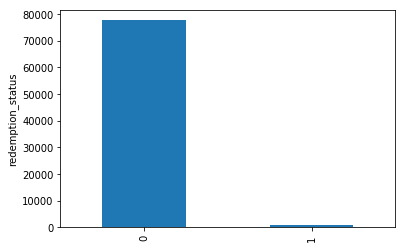

In [8]:
value=train['redemption_status'].value_counts().plot(kind='bar')
plt.ylabel('redemption_status')

Inference

The dataset is highly imbalanced. As of now proceeding with the same imbalanced data.

# Cleaning, Preprocessing and Feature Engineering

## Dealing with Customer Demographic Dataframe

In [9]:
cust_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [10]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
customer_id       760 non-null int64
age_range         760 non-null object
marital_status    431 non-null object
rented            760 non-null int64
family_size       760 non-null object
no_of_children    222 non-null object
income_bracket    760 non-null int64
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [11]:
cust_demo.marital_status.value_counts()

Married    317
Single     114
Name: marital_status, dtype: int64

In [12]:
cust_demo.family_size.value_counts()

2     303
1     248
3     104
5+     57
4      48
Name: family_size, dtype: int64

In [13]:
    cust_demo.no_of_children.value_counts()

1     107
3+     60
2      55
Name: no_of_children, dtype: int64

In [14]:
#The below lines of code is to get rid of the + and keeping 5+ as 5 and 3+ as 3 and converting the columns to int data type.
#type of family size = int64 ... Cant apply astype as we have 5+ as family size
#no of children = int64 ... we need to ignore the NaN values while converting to float
cust_demo['family_size'] = cust_demo.family_size.apply(lambda x: int(re.sub('\+','',x)))
cust_demo['no_of_children'] = cust_demo.no_of_children.apply(lambda x: int(re.sub('\+','',x)) if pd.notna(x) else x)

In [15]:
#Filling NaN values for marital_status

#customers with family size =1 will be single
cust_demo.loc[pd.isnull(cust_demo.marital_status) & (cust_demo.family_size == 1),'marital_status'] = 'Single'

#customers whos family size - no of childrens == 1, will also be single 
#This is applicable where there is only 1 parent --- We treat 1 parent as Single
cust_demo.loc[(cust_demo.family_size - cust_demo.no_of_children == 1) & pd.isnull(cust_demo.marital_status),'marital_status'] = 'Single'

#from the orignal data we have 186 of 196 customers with diff of 2 in their family size and number of childrens as
#Married (see the below cell) and hence where ever the difference is 2 and marital status is NaN and No of Children is 
#NaN we impute the Mariatl Status with Married
cust_demo.loc[(pd.isnull(cust_demo.marital_status)) & ((cust_demo.family_size - cust_demo.no_of_children) == 2)  
              & (pd.notnull(cust_demo.no_of_children)),'marital_status'] = 'Married'

#original data shows customers with fam size == 2, and NaN in no of childrens are majorly Married (see below cell skipping 1 cell)
cust_demo.loc[pd.isnull(cust_demo.marital_status) & (pd.isnull(cust_demo.no_of_children)) 
              & (cust_demo.family_size ==2),'marital_status'] = 'Married'

In [16]:
a = cust_demo.marital_status.groupby((cust_demo.family_size - cust_demo.no_of_children) == 2).value_counts()
print(a[True])

marital_status
Married    186
Single      10
Name: marital_status, dtype: int64


In [17]:
#b = cust_demo.marital_status.groupby((cust_demo.family_size) == 2 & pd.isnull(cust_demo.no_of_children)).value_counts()

In [18]:
cust_demo.marital_status.isnull().sum()

0

In [19]:
#FillingNaN values for no of children

#Married people with family_size ==2 will have 0 childrens
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.marital_status == 'Married') & (cust_demo.family_size == 2),'no_of_children'] = 0

#customers with family size 1 will have zero childrens
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.family_size == 1), 'no_of_children'] = 0

#singles with family size == 2, will probably have 1 child
cust_demo.loc[pd.isnull(cust_demo.no_of_children) & (cust_demo.family_size == 2),'no_of_children'] = 1

cust_demo['no_of_children']=cust_demo['no_of_children'].astype(np.int64)

In [20]:
cust_demo.no_of_children.isnull().sum()

0

In [21]:
cust_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
customer_id       760 non-null int64
age_range         760 non-null object
marital_status    760 non-null object
rented            760 non-null int64
family_size       760 non-null int64
no_of_children    760 non-null int64
income_bracket    760 non-null int64
dtypes: int64(5), object(2)
memory usage: 41.7+ KB


In [22]:
#Label Encoding Marital Status --- 0 is Single and 1 is Married
cust_demo["marital_status"] = encoder.fit_transform(cust_demo["marital_status"])

In [23]:
# Label Encoding age_range ... 18-25 is 0, 26-35 is 1, 36-45 is 2, 46-55 is 3, 56-70 is 4 and 70+ is 5
cust_demo["age_range"] = encoder.fit_transform(cust_demo["age_range"])

In [24]:
cust_demo.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,5,0,0,2,0,4
1,6,3,0,0,2,0,5
2,7,1,0,0,3,1,3
3,8,1,0,0,4,2,6
4,10,3,1,0,1,0,5


## Dealing with Campaign Dataframe

In [25]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date
0,24,Y,21/10/13,20/12/13
1,25,Y,21/10/13,22/11/13
2,20,Y,07/09/13,16/11/13
3,23,Y,08/10/13,15/11/13
4,21,Y,16/09/13,18/10/13


In [26]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
campaign_id      28 non-null int64
campaign_type    28 non-null object
start_date       28 non-null object
end_date         28 non-null object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [27]:
campaign.campaign_type.value_counts()

Y    22
X     6
Name: campaign_type, dtype: int64

In [28]:
#Label Encoding Campaign type
campaign["campaign_type"] = encoder.fit_transform(campaign.campaign_type)

In [29]:
#Converting the date columns to date time
campaign['start_date'] = pd.to_datetime(campaign['start_date'], format = '%d/%m/%y')
campaign['end_date'] = pd.to_datetime(campaign['end_date'], format = '%d/%m/%y')

In [30]:
#Creating a new column campaign_duration
campaign["campaign_duration"] = campaign["end_date"] - campaign["start_date"]
campaign["campaign_duration"] = campaign["campaign_duration"].apply(lambda x: x.days) 

In [31]:
campaign.head()

,campaign_id,campaign_type,start_date,end_date,campaign_duration
0,24,1,2013-10-21,2013-12-20,60
1,25,1,2013-10-21,2013-11-22,32
2,20,1,2013-09-07,2013-11-16,70
3,23,1,2013-10-08,2013-11-15,38
4,21,1,2013-09-16,2013-10-18,32


## Dealing with Customer Transaction Dataframe

In [32]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [33]:
cust_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
date               1324566 non-null object
customer_id        1324566 non-null int64
item_id            1324566 non-null int64
quantity           1324566 non-null int64
selling_price      1324566 non-null float64
other_discount     1324566 non-null float64
coupon_discount    1324566 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [34]:
#Converting the date column into date time
#Reset the index of the DataFrame, and use the default one instead.
#If the DataFrame has a MultiIndex, this method can remove one or more levels.
cust_tran['date'] = pd.to_datetime(cust_tran['date'])
cust_tran = cust_tran.sort_values('date').reset_index(drop=True)

In [35]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62
2,2012-01-02,464,20717,2,28.50,-27.78,0.00
3,2012-01-02,464,21008,1,35.26,-17.81,0.00
4,2012-01-02,464,22243,2,118.97,-22.80,0.00


In [36]:
#Creating 3 new columns from the date column
cust_tran['day'] = cust_tran["date"].apply(lambda x: x.day)
cust_tran['dow'] = cust_tran["date"].apply(lambda x: x.weekday())
cust_tran['month'] = cust_tran["date"].apply(lambda x: x.month)

In [37]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month
0,2012-01-02,1501,26830,1,35.26,-10.69,0.00,2,0,1
1,2012-01-02,464,20697,1,92.26,-21.37,-35.62,2,0,1
2,2012-01-02,464,20717,2,28.50,-27.78,0.00,2,0,1
3,2012-01-02,464,21008,1,35.26,-17.81,0.00,2,0,1
4,2012-01-02,464,22243,2,118.97,-22.80,0.00,2,0,1


In [38]:
#Given selling_price and other_discount are for the entire transaction. Hence getting the Actual value of the transaction.
cust_tran.selling_price = cust_tran.selling_price/cust_tran.quantity
cust_tran.other_discount = cust_tran.other_discount/cust_tran.quantity
cust_tran.selling_price = cust_tran.selling_price - cust_tran.other_discount

In [39]:
#Inserting a new column to know if the coupon was used or not
cust_tran['coupon_used'] = cust_tran.coupon_discount.apply(lambda x: 1 if x !=0 else 0)

In [40]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month,coupon_used
0,2012-01-02,1501,26830,1,45.950,-10.69,0.00,2,0,1,0
1,2012-01-02,464,20697,1,113.630,-21.37,-35.62,2,0,1,1
2,2012-01-02,464,20717,2,28.140,-13.89,0.00,2,0,1,0
3,2012-01-02,464,21008,1,53.070,-17.81,0.00,2,0,1,0
4,2012-01-02,464,22243,2,70.885,-11.40,0.00,2,0,1,0


## Dealing with Items Dataframe

In [41]:
items.head()

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [42]:
items.brand_type.value_counts()

Established    62842
Local          11224
Name: brand_type, dtype: int64

In [43]:
items.category.value_counts()

Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: category, dtype: int64

In [44]:
#Label Encoding the brand_type and category columns
items.brand_type = encoder.fit_transform(items["brand_type"])
items.category = encoder.fit_transform(items["category"])

In [45]:
items.head()

,item_id,brand,brand_type,category
0,1,1,0,6
1,2,1,0,8
2,3,56,1,1
3,4,56,1,6
4,5,56,1,6


# Dealing with Coupoun Dataframe

In [46]:
coupons.head()

,coupon_id,item_id
0,105,37
1,107,75
2,494,76
3,522,77
4,518,77


# Now we can Start with Merging the Data Frames As all the Dataframes have data in the proper format

## Let us see the schema first before proceeding

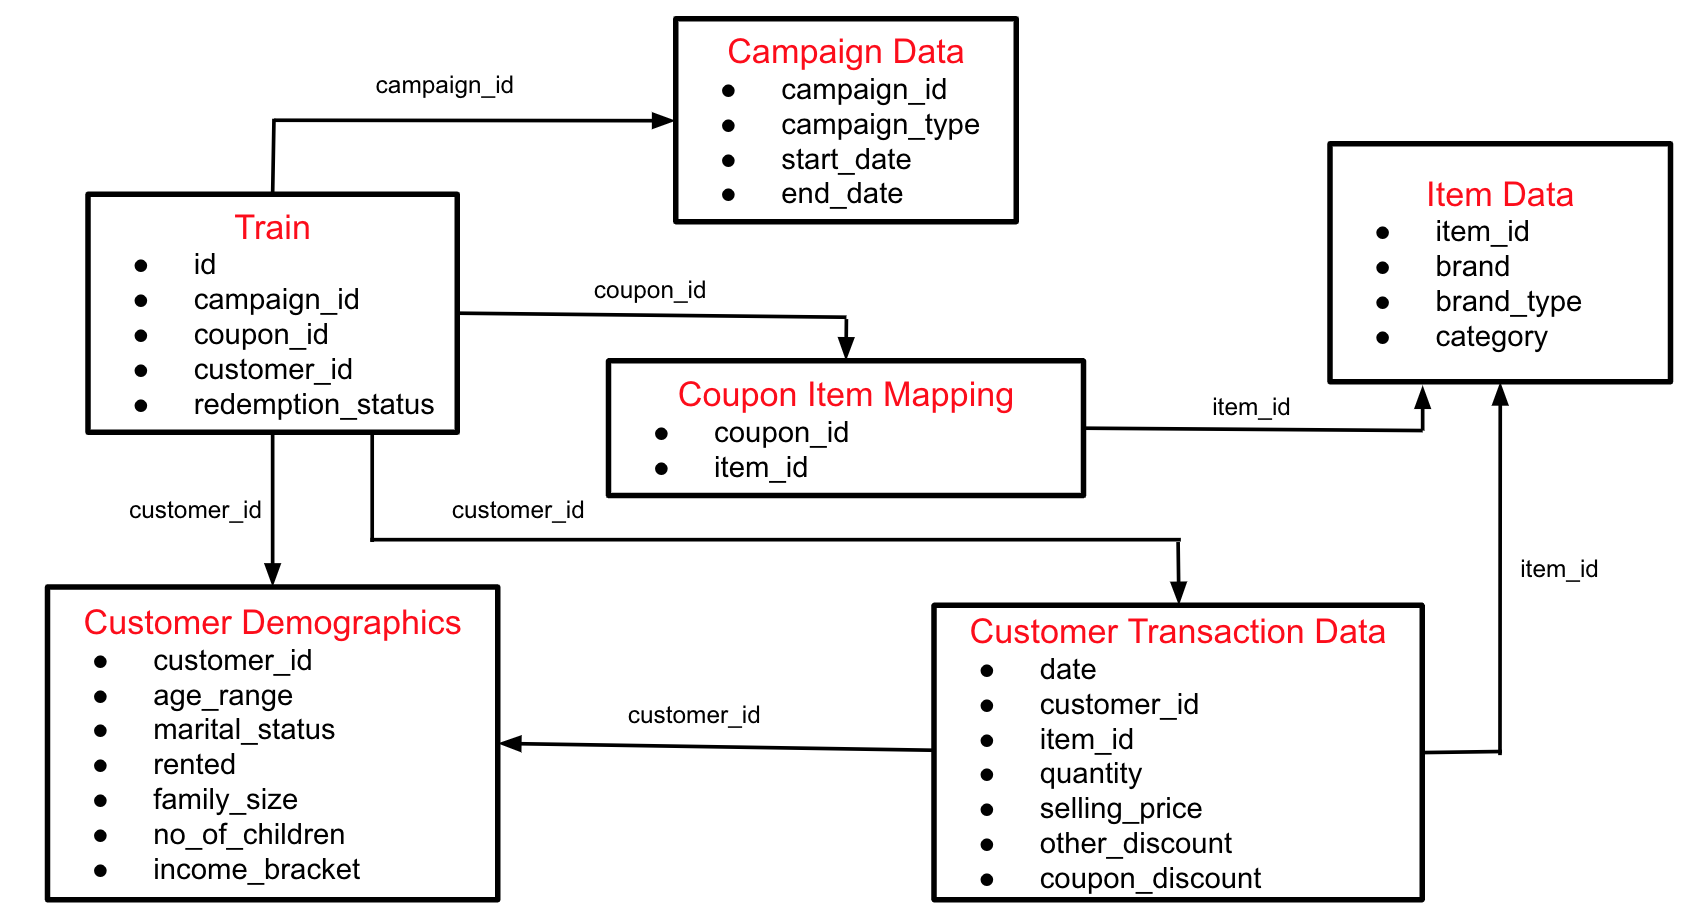

In [47]:
Image("../input/Schema.png")

## Merging Train and Test Data with Other Data

1. Merge coupon item data and items data on item_id
2. Aggregate transactions by item_id
3. Merge 1 and 2 on item_id
4. Aggregate 3 on coupon_id
5. Merge 4 and train on coupon_id
6. Aggregate transactions on customer_id
7. Merge 5 with campaign data on campaign_id
8. Merge 7 with customer demographic data on customer_id
9. Merge 6 with 8 on customer_id respectively

### Step 1: 
Merging coupons and items data on 'item_id'

In [48]:
coupons_items = pd.merge(coupons, items, on="item_id", how="left")

In [49]:
coupons_items.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,1,6
1,107,75,56,1,6
2,494,76,209,0,6
3,522,77,278,0,6
4,518,77,278,0,6


### Step 2:
Aggregate the customer transaction by 'item_id'

Before getting into the below code ... Understand the working of pd.pivot_table here
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html

Following Blog is an excellent demonstration of the working of Pivot tables in Python
https://pbpython.com/pandas-pivot-table-explained.html

In [50]:
cust_tran.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,day,dow,month,coupon_used
0,2012-01-02,1501,26830,1,45.950,-10.69,0.00,2,0,1,0
1,2012-01-02,464,20697,1,113.630,-21.37,-35.62,2,0,1,1
2,2012-01-02,464,20717,2,28.140,-13.89,0.00,2,0,1,0
3,2012-01-02,464,21008,1,53.070,-17.81,0.00,2,0,1,0
4,2012-01-02,464,22243,2,70.885,-11.40,0.00,2,0,1,0


In [51]:
# Aggregate transactions by item_id by mean for a particular customer
transactions1 = pd.pivot_table(cust_tran, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used'],
               aggfunc={'customer_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum
                        } )
transactions1.reset_index(inplace=True)
transactions1.rename(columns={'customer_id': 'no_of_customers'}, inplace=True)

In [52]:
transactions1.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price
0,1,0.0,0,2,0.0,1.0,124.31
1,2,0.0,0,1,0.0,1.0,35.26
2,3,0.0,0,1,0.0,1.0,56.64
3,4,0.0,0,1,0.0,1.0,54.85
4,5,0.0,0,1,0.0,1.0,81.57


In [53]:
# Aggregate transactions by item_id by sum for a particular customer
transactions2 = pd.pivot_table(cust_tran, index = "item_id", 
               values=['customer_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'customer_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum,
                        } )
transactions2.reset_index(inplace=True)
transactions2.rename(columns={'customer_id': 't_counts', 'quantity':'qu_sum',
                             'selling_price':'price_sum', 'other_discount':'od_sum',
                             'coupon_discount':'cd_sum'}, inplace=True)

In [54]:
transactions2.head()

,item_id,cd_sum,t_counts,od_sum,qu_sum,price_sum
0,1,0.0,2,0.0,2,248.62
1,2,0.0,1,0.0,1,35.26
2,3,0.0,1,0.0,1,56.64
3,4,0.0,1,0.0,1,54.85
4,5,0.0,1,0.0,1,81.57


In [55]:
transactions1 = pd.merge(transactions1, transactions2, on='item_id',how='left' )

In [56]:
transactions1['total_discount_mean'] = transactions1['coupon_discount'] + transactions1['other_discount']
transactions1['total_discount_sum'] = transactions1['od_sum'] + transactions1['cd_sum']
transactions1.head()

,item_id,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,cd_sum,t_counts,od_sum,qu_sum,price_sum,total_discount_mean,total_discount_sum
0,1,0.0,0,2,0.0,1.0,124.31,0.0,2,0.0,2,248.62,0.0,0.0
1,2,0.0,0,1,0.0,1.0,35.26,0.0,1,0.0,1,35.26,0.0,0.0
2,3,0.0,0,1,0.0,1.0,56.64,0.0,1,0.0,1,56.64,0.0,0.0
3,4,0.0,0,1,0.0,1.0,54.85,0.0,1,0.0,1,54.85,0.0,0.0
4,5,0.0,0,1,0.0,1.0,81.57,0.0,1,0.0,1,81.57,0.0,0.0


### Step 3:
Merge coupon_items and transaction1 on 'item_id'

In [57]:
item_coupon_trans = pd.merge(coupons_items, transactions1, on='item_id', how='left')

In [58]:
item_coupon_trans.head()

,coupon_id,item_id,brand,brand_type,category,coupon_discount,coupon_used,no_of_customers,other_discount,quantity,selling_price,cd_sum,t_counts,od_sum,qu_sum,price_sum,total_discount_mean,total_discount_sum
0,105,37,56,1,6,0.0,0.0,2.0,-8.108333,2.285714,57.247381,0.0,7.0,-56.758333,16.0,400.731667,-8.108333,-56.758333
1,107,75,56,1,6,0.0,0.0,4.0,-2.633712,1.363636,38.828485,0.0,33.0,-86.912500,45.0,1281.340000,-2.633712,-86.912500
2,494,76,209,0,6,0.0,0.0,1.0,-17.450000,1.000000,106.500000,0.0,1.0,-17.450000,1.0,106.500000,-17.450000,-17.450000
3,522,77,278,0,6,0.0,0.0,2.0,-16.920000,1.000000,87.270000,0.0,2.0,-33.840000,2.0,174.540000,-16.920000,-33.840000
4,518,77,278,0,6,0.0,0.0,2.0,-16.920000,1.000000,87.270000,0.0,2.0,-33.840000,2.0,174.540000,-16.920000,-33.840000


In [59]:
item_coupon_trans.columns

Index(['coupon_id', 'item_id', 'brand', 'brand_type', 'category',
       'coupon_discount', 'coupon_used', 'no_of_customers', 'other_discount',
       'quantity', 'selling_price', 'cd_sum', 't_counts', 'od_sum', 'qu_sum',
       'price_sum', 'total_discount_mean', 'total_discount_sum'],
      dtype='object')

### Step 4:
Now Aggregating item_coupon_trans on 'coupon_id'

In [60]:
coupon = pd.pivot_table(item_coupon_trans, index ="coupon_id",
                         values=[ 'item_id', 'brand', 'brand_type', 'category',
       'coupon_discount', 'coupon_used', 'no_of_customers', 'other_discount',
       'quantity', 'selling_price', 'cd_sum', 't_counts', 'od_sum', 'qu_sum',
       'price_sum', 'total_discount_mean', 'total_discount_sum'],
              aggfunc={'item_id':lambda x: len(set(x)),
                       'brand':lambda x: mode(x)[0][0],
                       'brand_type':lambda x: mode(x)[0][0],
                       'category':lambda x: mode(x)[0][0],
                       'coupon_discount':np.mean,
                       'no_of_customers':np.mean,
                       'other_discount':np.mean,
                       'quantity':np.mean,
                       'selling_price':np.mean,
                      'coupon_used': np.sum,
                       'cd_sum': np.sum,
                       't_counts': np.sum,
                       'od_sum': np.sum,
                       'qu_sum': np.sum,
                       'price_sum': np.sum,
                       'total_discount_mean': np.mean,
                       'total_discount_sum': np.sum
                      })
coupon.reset_index(inplace=True)

In [61]:
coupon.rename(columns={'item_id':'item_counts'}, inplace=True)

In [62]:
coupon.head()

,coupon_id,brand,brand_type,category,cd_sum,coupon_discount,coupon_used,item_counts,no_of_customers,od_sum,other_discount,price_sum,qu_sum,quantity,selling_price,t_counts,total_discount_mean,total_discount_sum
0,1,1475,0,9,-1526.31,-1.321524,35.0,39,14.794872,-18780.020833,-16.620713,89796.868333,1034.0,1.221644,101.183245,826.0,-17.942237,-20306.330833
1,2,2084,0,6,0.00,0.000000,0.0,2,15.000000,-1163.521667,-21.343885,8940.520000,103.0,1.137500,122.534500,81.0,-21.343885,-1163.521667
2,3,278,0,6,-578.81,-2.747358,15.0,17,8.588235,-4055.343333,-14.728021,27756.490000,248.0,1.121525,131.655894,212.0,-17.475379,-4634.153333
3,4,544,0,6,-881.59,-1.485152,44.0,24,22.333333,-25895.740000,-36.718597,142874.023333,702.0,1.020872,211.708369,676.0,-38.203749,-26777.330000
4,5,5357,0,11,0.00,0.000000,0.0,7,6.000000,-1228.880000,-27.265786,16636.570000,44.0,1.000000,403.970000,44.0,-27.265786,-1228.880000


### Step 6:
Aggregating cust_trans on 'coupon_id'

In [63]:
# Aggregate transactions by customer_id
transactions3 = pd.pivot_table(cust_tran, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount','coupon_used','day','dow','month'],
               aggfunc={'item_id':lambda x: len(set(x)),
                        'quantity':np.mean,
                        'selling_price':np.mean,
                        'other_discount':np.mean,
                        'coupon_discount':np.mean,
                        'coupon_used': np.sum,
                        'day':lambda x: mode(x)[0][0],
                        'dow':lambda x: mode(x)[0][0],
                        'month':lambda x: mode(x)[0][0]}
              )
transactions3.reset_index(inplace=True)
transactions3.rename(columns={'item_id': 'no_of_items'}, inplace=True)
transactions3.head()

,customer_id,coupon_discount,coupon_used,day,dow,no_of_items,month,other_discount,quantity,selling_price
0,1,-2.019876,78,3,3,463,5,-12.837537,1.170802,97.470480
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,107.805783
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,85.082452
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,138.256770
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,115.482842


In [64]:
# Aggregate transactions by customer_id by sum
transactions4 = pd.pivot_table(cust_tran, index = "customer_id", 
               values=['item_id','quantity','selling_price', 'other_discount','coupon_discount'],
               aggfunc={'item_id':len,
                        'quantity':np.sum,
                        'selling_price':np.sum,
                        'other_discount':np.sum,
                        'coupon_discount':np.sum}
              )
transactions4.reset_index(inplace=True)
transactions4.rename(columns={'item_id': 'customer_id_count','quantity':'qa_sum','selling_price':'pprice_sum',
                             'other_discount':'odd_sum','coupon_discount':'cdd_sum'  }, inplace=True)
transactions4.head()

,customer_id,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,1,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-249.34,419,-5628.089833,474,45170.623167
2,3,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-89.05,220,-1954.404333,280,30416.489333
4,5,-90.83,792,-8918.471477,93353,91462.410620


In [65]:
transactions = pd.merge(transactions3, transactions4, on='customer_id', how='left')
transactions.head()

,customer_id,coupon_discount,coupon_used,day,dow,no_of_items,month,other_discount,quantity,selling_price,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,1,-2.019876,78,3,3,463,5,-12.837537,1.170802,97.470480,-2116.83,1048,-13453.738833,1227,102149.063000
1,2,-0.595084,4,13,5,352,6,-13.432195,1.131265,107.805783,-249.34,419,-5628.089833,474,45170.623167
2,3,-3.091546,53,16,4,406,7,-14.074853,11.578723,85.082452,-2179.54,705,-9922.771654,8163,59983.128347
3,4,-0.404773,1,14,5,125,5,-8.883656,1.272727,138.256770,-89.05,220,-1954.404333,280,30416.489333
4,5,-0.114684,2,11,1,490,5,-11.260696,117.869949,115.482842,-90.83,792,-8918.471477,93353,91462.410620


### Step 5,7,8,9

Merge 4 and train on coupon_id

Merge 5 with campaign data on campaign_id

Merge 7 with customer demographic data on customer_id

Merge 6 with 8 on customer_id respectively

In [66]:
def merge_all(df): 
    df=  pd.merge(df, coupon, on="coupon_id", how="left")
    df = pd.merge(df, campaign, on="campaign_id", how="left")
    df = pd.merge(df, cust_demo, on="customer_id", how="left")
    df = pd.merge(df, transactions, on='customer_id', how='left')
    return df

In [67]:
train = merge_all(train)
test = merge_all(test)

In [68]:
train.shape, test.shape

((78369, 46), (50226, 45))

In [69]:
## To save the final file after merging the data
##train.to_csv('FinalData.csv')

# Data is Ready here, But we need to check for Null Values which could have been created while merging.

In [70]:
train.isnull().sum()

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
redemption_status          0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
item_counts                0
no_of_customers            0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
t_counts                   0
total_discount_mean        0
total_discount_sum         0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              34708
marital_status         34708
rented                 34708
family_size            34708
no_of_children         34708
income_bracket         34708
coupon_discount_y          0
coupon_used_y              0
day           

In [71]:
test.isnull().sum()

id                         0
campaign_id                0
coupon_id                  0
customer_id                0
brand                      0
brand_type                 0
category                   0
cd_sum                     0
coupon_discount_x          0
coupon_used_x              0
item_counts                0
no_of_customers            0
od_sum                     0
other_discount_x           0
price_sum                  0
qu_sum                     0
quantity_x                 0
selling_price_x            0
t_counts                   0
total_discount_mean        0
total_discount_sum         0
campaign_type              0
start_date                 0
end_date                   0
campaign_duration          0
age_range              19287
marital_status         19287
rented                 19287
family_size            19287
no_of_children         19287
income_bracket         19287
coupon_discount_y          0
coupon_used_y              0
day                        0
dow           

**Observation**

There are missing values in:

1. age_range
2. marital_status
3. rented
4. family_size
5. no_of_children
6. income_bracke

### As all of these columns are present in cust_demo dataframe, filling the NaN's with the mode.

In [72]:
def deal_na(df):
    for col in cust_demo.columns.tolist()[1:]:
        df[col].fillna(mode(df[col]).mode[0], inplace=True)
    return df

train = deal_na(train)
test = deal_na(test)

In [73]:
train.isnull().sum()

id                     0
campaign_id            0
coupon_id              0
customer_id            0
redemption_status      0
brand                  0
brand_type             0
category               0
cd_sum                 0
coupon_discount_x      0
coupon_used_x          0
item_counts            0
no_of_customers        0
od_sum                 0
other_discount_x       0
price_sum              0
qu_sum                 0
quantity_x             0
selling_price_x        0
t_counts               0
total_discount_mean    0
total_discount_sum     0
campaign_type          0
start_date             0
end_date               0
campaign_duration      0
age_range              0
marital_status         0
rented                 0
family_size            0
no_of_children         0
income_bracket         0
coupon_discount_y      0
coupon_used_y          0
day                    0
dow                    0
no_of_items            0
month                  0
other_discount_y       0
quantity_y             0


In [74]:
test.isnull().sum()

id                     0
campaign_id            0
coupon_id              0
customer_id            0
brand                  0
brand_type             0
category               0
cd_sum                 0
coupon_discount_x      0
coupon_used_x          0
item_counts            0
no_of_customers        0
od_sum                 0
other_discount_x       0
price_sum              0
qu_sum                 0
quantity_x             0
selling_price_x        0
t_counts               0
total_discount_mean    0
total_discount_sum     0
campaign_type          0
start_date             0
end_date               0
campaign_duration      0
age_range              0
marital_status         0
rented                 0
family_size            0
no_of_children         0
income_bracket         0
coupon_discount_y      0
coupon_used_y          0
day                    0
dow                    0
no_of_items            0
month                  0
other_discount_y       0
quantity_y             0
selling_price_y        0


## Now Dropping off the Unwanted Columns and making the data ready for Model Building

In [75]:
test_id = test['id']
target = train['redemption_status']
train.drop(['id','campaign_id','start_date','end_date', 'redemption_status'], axis=1, inplace=True)
test.drop(['id','campaign_id','start_date','end_date'], axis=1, inplace=True)

In [76]:
train.head()

,coupon_id,customer_id,brand,brand_type,category,cd_sum,coupon_discount_x,coupon_used_x,item_counts,no_of_customers,od_sum,other_discount_x,price_sum,qu_sum,quantity_x,selling_price_x,t_counts,total_discount_mean,total_discount_sum,campaign_type,campaign_duration,age_range,marital_status,rented,family_size,no_of_children,income_bracket,coupon_discount_y,coupon_used_y,day,dow,no_of_items,month,other_discount_y,quantity_y,selling_price_y,cdd_sum,customer_id_count,odd_sum,qa_sum,pprice_sum
0,27,1053,1105,0,6,-5349.93,-1.241694,191.0,125,19.224000,-177447.090167,-44.367382,436274.446738,4661.0,1.169768,117.276864,3713.0,-45.609077,-182797.020167,0,47,3.0,1.0,0.0,1.0,0.0,5.0,-0.287258,1,11,2,208,5,-25.583099,340.487097,163.966826,-89.05,310,-7930.760842,105551,50829.715972
1,116,48,56,1,6,0.00,0.000000,0.0,3,20.333333,-586.140000,-10.207037,5323.510000,86.0,1.050926,70.885046,75.0,-10.207037,-586.140000,0,47,2.0,0.0,0.0,2.0,0.0,3.0,-3.215039,12,4,5,244,6,-20.013685,31.540260,188.638474,-1237.79,385,-7705.268702,12143,72625.812434
2,635,205,560,0,11,-605.54,-2.987321,15.0,67,1.761194,-12475.083333,-76.767366,48980.998333,202.0,1.353802,342.826195,142.0,-79.754687,-13080.623333,1,32,3.0,0.0,0.0,2.0,0.0,7.0,-2.212082,85,27,2,533,3,-12.873370,1.392784,112.067666,-2145.72,970,-12487.169143,1351,108705.636349
3,644,1050,611,0,6,-17.81,-4.452500,1.0,4,3.500000,-260.750000,-4.451964,3697.783333,47.0,1.110390,88.694903,39.0,-8.904464,-278.560000,0,47,3.0,0.0,0.0,2.0,0.0,5.0,-0.751477,2,9,4,216,8,-12.880868,1.291139,100.896997,-178.10,237,-3052.765833,306,23912.588333
4,1017,1489,1558,0,6,-569.92,-0.198055,23.0,32,27.312500,-46796.046667,-30.665116,289181.848333,1610.0,1.071044,200.991719,1420.0,-30.863170,-47365.966667,0,48,3.0,0.0,0.0,2.0,0.0,3.0,-0.471548,10,2,4,327,5,-12.264174,247.443060,85.016352,-265.01,562,-6892.466021,139063,47779.189609


In [77]:
train.columns

Index(['coupon_id', 'customer_id', 'brand', 'brand_type', 'category', 'cd_sum',
       'coupon_discount_x', 'coupon_used_x', 'item_counts', 'no_of_customers',
       'od_sum', 'other_discount_x', 'price_sum', 'qu_sum', 'quantity_x',
       'selling_price_x', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'campaign_duration', 'age_range',
       'marital_status', 'rented', 'family_size', 'no_of_children',
       'income_bracket', 'coupon_discount_y', 'coupon_used_y', 'day', 'dow',
       'no_of_items', 'month', 'other_discount_y', 'quantity_y',
       'selling_price_y', 'cdd_sum', 'customer_id_count', 'odd_sum', 'qa_sum',
       'pprice_sum'],
      dtype='object')

In [78]:
train.shape

(78369, 41)

In [79]:
target

0        0
1        0
2        0
3        0
4        0
        ..
78364    0
78365    0
78366    0
78367    0
78368    0
Name: redemption_status, Length: 78369, dtype: int64

# Note ... If Possible do the EDA here ... Univariate and Bivariate Analysis

# Model Building - To be Covered Are:
1. Logistic Regression
2. kNN
3. Naive Bayes
4. Decision Tree
5. Random Forest
6. Logistic Regression -- Bagged
7. kNN -- Bagged
8. Naive Bayes - Bagged
9. Decision Tree -- Bagged
10. Logistic Regression -- Boosted
11. Naive Bayes -- Boosted
12. Decision Tree -- Boosted
13. Random Forest --Boosted
14. Gradient Boosting Classifier
15. Light GBM (LGBM)

In [80]:
x = pd.DataFrame(train)
y = target
col_names = ['cd_sum','coupon_discount_x', 'coupon_used_x', 'item_counts', 'no_of_customers',
       'od_sum', 'other_discount_x', 'price_sum', 'qu_sum', 'quantity_x',
       'selling_price_x', 't_counts', 'total_discount_mean',
       'total_discount_sum', 'campaign_type', 'campaign_duration',
        'family_size', 'no_of_children',
       'income_bracket', 'coupon_discount_y', 'coupon_used_y',
       'no_of_items', 'other_discount_y', 'quantity_y',
       'selling_price_y', 'cdd_sum', 'customer_id_count', 'odd_sum', 'qa_sum',
       'pprice_sum']
features = x[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
x[col_names] = features
x = np.array(x)

In [81]:
x

array([[ 2.70000000e+01,  1.05300000e+03,  1.10500000e+03, ...,
         6.38586958e-01, -1.47977262e-01, -7.90890632e-01],
       [ 1.16000000e+02,  4.80000000e+01,  5.60000000e+01, ...,
         6.62184374e-01, -5.34847193e-01, -4.71808694e-01],
       [ 6.35000000e+02,  2.05000000e+02,  5.60000000e+02, ...,
         1.61765625e-01, -5.79544652e-01,  5.63785504e-02],
       ...,
       [ 7.54000000e+02,  1.00400000e+03,  8.64000000e+02, ...,
        -7.89315048e-01,  1.13435780e-01,  1.11114774e+00],
       [ 1.34000000e+02,  7.10000000e+01,  1.10000000e+01, ...,
        -2.53295326e-01, -5.10816924e-01, -3.61970883e-01],
       [ 6.81000000e+02,  6.23000000e+02,  6.86000000e+02, ...,
         4.89657361e-01,  8.86918856e-01, -4.29600563e-01]])

In [82]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=2439)

In [83]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((54858, 41), (54858,), (23511, 41), (23511,))

# Logistic Regression

In [84]:
LR = LogisticRegression()
LR.fit(x_train,y_train)
y_pred_LR = LR.predict(x_test)
print(classification_report(y_test,y_pred_LR))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.50      0.00      0.01       207

    accuracy                           0.99     23511
   macro avg       0.75      0.50      0.50     23511
weighted avg       0.99      0.99      0.99     23511



In [85]:
roc_auc_score(y_test,y_pred_LR)
Model = ['Logistic Regression']
ROC_AUC_Accuracy = [roc_auc_score(y_test,y_pred_LR)]

In [86]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
results=confusion_matrix(y_test,y_pred_LR)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_LR) )
print ('Report : ')
print (classification_report(y_test,y_pred_LR) )

Confusion Matrix :
[[23303     1]
 [  206     1]]
Accuracy Score : 0.9911956105652673
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.50      0.00      0.01       207

    accuracy                           0.99     23511
   macro avg       0.75      0.50      0.50     23511
weighted avg       0.99      0.99      0.99     23511



In [87]:
#Function to visulise confusion matrix
def draw_cm( y_test,y_pred_LR ):
    cm = metrics.confusion_matrix( y_test,y_pred_LR )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] , cmap="Greens")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [88]:
#Confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
mat_pruned = confusion_matrix(y_test,y_pred_LR )

print("confusion matrix = \n",mat_pruned)

confusion matrix = 
 [[23303     1]
 [  206     1]]


In [89]:
def create_conf_mat(y_test,y_pred_LR):
    if (len(y_test.shape) != len(y_pred_LR.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != y_pred_LR.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = y_test,
                                       columns = y_pred_LR)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

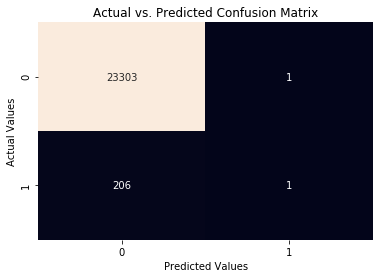

In [90]:
    conf_mat = create_conf_mat(y_test,y_pred_LR)
    sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Actual vs. Predicted Confusion Matrix')
    plt.show()

In [91]:
#Get predicted probabilites
target_probailities_log = LR.predict_proba(x_test)[:,1]

In [92]:
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)

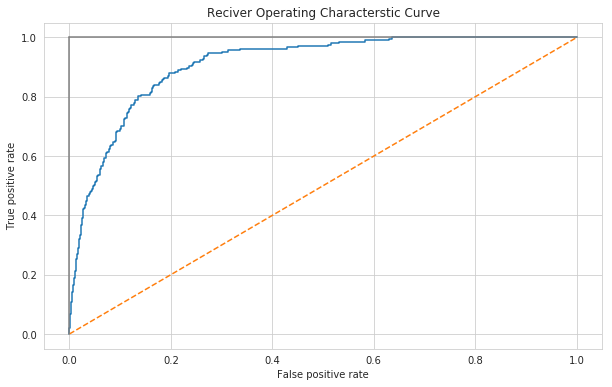

In [93]:
#Plot ROC Curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# kNN

## Caution --- Algorithm - 'brute' was crashing the system, hence removed it.

In [94]:
params = {
    
    'n_neighbors': range(1,5),
    'weights': ['uniform','distance'],
    'algorithm': ['ball_tree','kd_tree','auto'],
    'p': [1,2,3]
}

knn = KNeighborsClassifier()

rs = RandomizedSearchCV(estimator=knn,n_jobs=-1,cv=3,param_distributions=params,scoring='recall')
rs.fit(x,y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=KNeighborsClassifier(algorithm='auto',
                                                  leaf_size=30,
                                                  metric='minkowski',
                                                  metric_params=None,
                                                  n_jobs=None, n_neighbors=5,
                                                  p=2, weights='uniform'),
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'algorithm': ['ball_tree', 'kd_tree',
                                                      'auto'],
                                        'n_neighbors': range(1, 5),
                                        'p': [1, 2, 3],
                                        'weights': ['uniform', 'distance']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, sc

In [95]:
knn = KNeighborsClassifier(**rs.best_params_)
knn.fit(x_train,y_train)
y_pred_knn = knn.predict(x_test)
print(roc_auc_score(y_test,y_pred_knn))
Model.append('k-Nearest-Neighbours')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_knn))

0.5416240665283562


In [96]:
print(classification_report(y_test,y_pred_knn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23304
           1       0.09      0.09      0.09       207

    accuracy                           0.98     23511
   macro avg       0.54      0.54      0.54     23511
weighted avg       0.98      0.98      0.98     23511



In [97]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'k-Nearest-Neighbours'],
 [0.5023940033930855, 0.5416240665283562])

In [98]:
results=confusion_matrix(y_test,y_pred_knn)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_knn) )
print ('Report : ')
print (classification_report(y_test,y_pred_knn) )


Confusion Matrix :
[[23105   199]
 [  188    19]]
Accuracy Score : 0.9835396197524563
Report : 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     23304
           1       0.09      0.09      0.09       207

    accuracy                           0.98     23511
   macro avg       0.54      0.54      0.54     23511
weighted avg       0.98      0.98      0.98     23511



In [99]:
#Function to visulise confusion matrix
def draw_cm( y_test,y_pred_knn ):
    cm = metrics.confusion_matrix( y_test,y_pred_knn )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] , cmap="Greens")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [100]:
#Confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
mat_pruned = confusion_matrix(y_test,y_pred_knn )

print("confusion matrix = \n",mat_pruned)


confusion matrix = 
 [[23105   199]
 [  188    19]]


In [101]:
def create_conf_mat(y_test,y_pred_knn):
    if (len(y_test.shape) != len(y_pred_knn.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != y_pred_knn.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = y_test,
                                       columns = y_pred_knn)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb


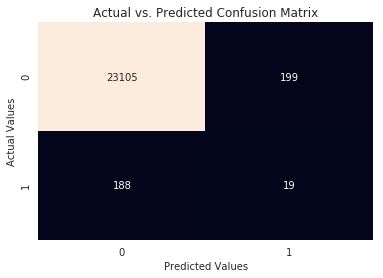

In [102]:
conf_mat = create_conf_mat(y_test,y_pred_knn)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [103]:
#Get predicted probabilites
target_probailities_log = knn.predict_proba(x_test)[:,1]

In [104]:
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)

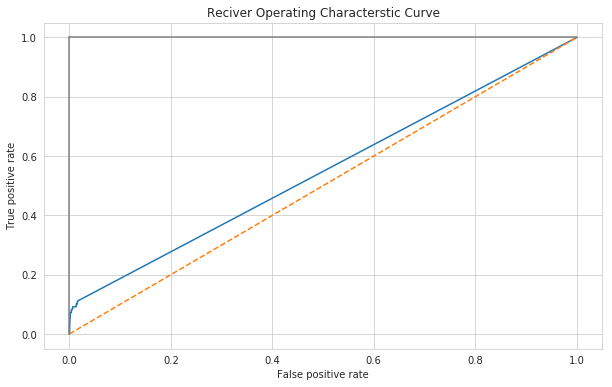

In [105]:
#Plot ROC Curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()


# Naive Bayes

In [106]:
nb = GaussianNB()
nb.fit(x_train,y_train)
y_pred_nb = nb.predict(x_test)
print(roc_auc_score(y_test,y_pred_nb))
Model.append('Naive Bayes')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_nb))

0.6388319850545033


In [107]:
print(classification_report(y_test,y_pred_nb))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     23304
           1       0.07      0.31      0.12       207

    accuracy                           0.96     23511
   macro avg       0.53      0.64      0.55     23511
weighted avg       0.99      0.96      0.97     23511



In [108]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'k-Nearest-Neighbours', 'Naive Bayes'],
 [0.5023940033930855, 0.5416240665283562, 0.6388319850545033])

In [109]:
results=confusion_matrix(y_test,y_pred_nb)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_nb) )
print ('Report : ')
print (classification_report(y_test,y_pred_nb) )

Confusion Matrix :
[[22457   847]
 [  142    65]]
Accuracy Score : 0.9579345838118327
Report : 
              precision    recall  f1-score   support

           0       0.99      0.96      0.98     23304
           1       0.07      0.31      0.12       207

    accuracy                           0.96     23511
   macro avg       0.53      0.64      0.55     23511
weighted avg       0.99      0.96      0.97     23511



In [110]:
#Function to visulise confusion matrix
def draw_cm( y_test,y_pred_nb ):
    cm = metrics.confusion_matrix( y_test,y_pred_nb )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] , cmap="Greens")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [111]:
#Confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
mat_pruned = confusion_matrix(y_test,y_pred_nb )

print("confusion matrix = \n",mat_pruned)


confusion matrix = 
 [[22457   847]
 [  142    65]]


In [112]:
def create_conf_mat(y_test,y_pred_nb):
    if (len(y_test.shape) != len(y_pred_nb.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != y_pred_nb.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = y_test,
                                       columns = y_pred_nb)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb


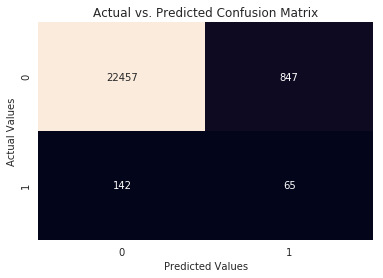

In [113]:
conf_mat = create_conf_mat(y_test,y_pred_nb)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()


In [114]:
#Get predicted probabilites
target_probailities_log = nb.predict_proba(x_test)[:,1]

In [115]:
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)

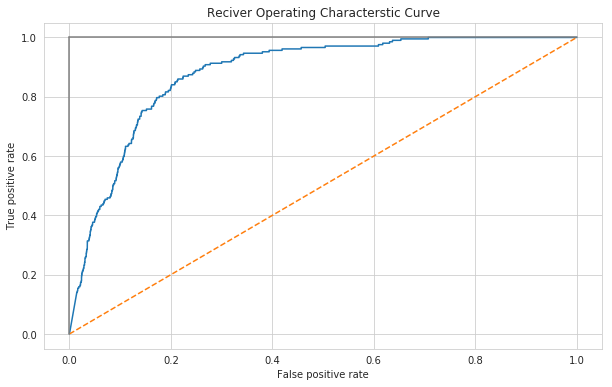

In [116]:
#Plot ROC Curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()


In [117]:
Model,ROC_AUC_Accuracy

(['Logistic Regression', 'k-Nearest-Neighbours', 'Naive Bayes'],
 [0.5023940033930855, 0.5416240665283562, 0.6388319850545033])

# Decision Tree

In [118]:
params = {
    
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':range(1,10),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

dt = DecisionTreeClassifier()

rs = RandomizedSearchCV(estimator=dt,n_jobs=-1,cv=3,param_distributions=params,scoring='recall')
rs.fit(x,y)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitter='best')

In [119]:
dt = DecisionTreeClassifier(**rs.best_params_)
dt.fit(x_train,y_train)
y_pred_dt = dt.predict(x_test)
print(roc_auc_score(y_test,y_pred_dt))
Model.append('Decision Tree')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_dt))

0.5


In [120]:
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.00      0.00      0.00       207

    accuracy                           0.99     23511
   macro avg       0.50      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



In [121]:
Model,ROC_AUC_Accuracy

(['Logistic Regression',
  'k-Nearest-Neighbours',
  'Naive Bayes',
  'Decision Tree'],
 [0.5023940033930855, 0.5416240665283562, 0.6388319850545033, 0.5])

In [122]:
results=confusion_matrix(y_test,y_pred_dt)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_dt) )
print ('Report : ')
print (classification_report(y_test,y_pred_dt) )

Confusion Matrix :
[[23304     0]
 [  207     0]]
Accuracy Score : 0.9911956105652673
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.00      0.00      0.00       207

    accuracy                           0.99     23511
   macro avg       0.50      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



In [123]:
#Function to visulise confusion matrix
def draw_cm( y_test,y_pred_dt):
    cm = metrics.confusion_matrix( y_test,y_pred_dt )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] , cmap="Greens")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [124]:
#Confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
mat_pruned = confusion_matrix(y_test,y_pred_dt )

print("confusion matrix = \n",mat_pruned)


confusion matrix = 
 [[23304     0]
 [  207     0]]


In [125]:
def create_conf_mat(y_test,y_pred_dt):
    if (len(y_test.shape) != len(y_pred_dt.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != y_pred_dt.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = y_test,
                                       columns = y_pred_dt)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

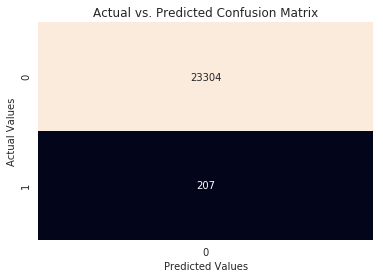

In [126]:
conf_mat = create_conf_mat(y_test,y_pred_dt)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [127]:
#Get predicted probabilites
target_probailities_log = dt.predict_proba(x_test)[:,1]

In [128]:
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)

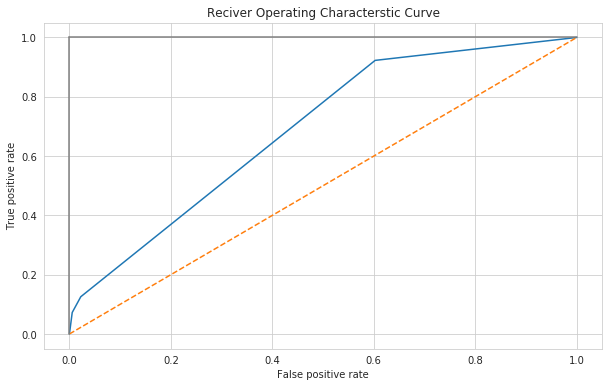

In [129]:
#Plot ROC Curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [130]:
Model,ROC_AUC_Accuracy

(['Logistic Regression',
  'k-Nearest-Neighbours',
  'Naive Bayes',
  'Decision Tree'],
 [0.5023940033930855, 0.5416240665283562, 0.6388319850545033, 0.5])

# Random Forest

In [131]:
params = {
    
    'n_estimators':range(10,100,10),
    'criterion':['gini','entropy'],
    'max_depth':range(2,10,1),
    'max_leaf_nodes':range(2,10,1),
    'max_features':['auto','log2']
    
}

rf = RandomForestClassifier()

rs = RandomizedSearchCV(estimator=rf,param_distributions=params,cv=5,scoring='recall',n_jobs=-1)
rs.fit(x,y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [132]:
rf = RandomForestClassifier(**rs.best_params_)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print(roc_auc_score(y_test,y_pred_rf))
Model.append('Random Forest')
ROC_AUC_Accuracy.append(roc_auc_score(y_test,y_pred_rf))

0.5


In [133]:
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.00      0.00      0.00       207

    accuracy                           0.99     23511
   macro avg       0.50      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



In [134]:
results=confusion_matrix(y_test,y_pred_rf)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test,y_pred_rf) )
print ('Report : ')
print (classification_report(y_test,y_pred_rf) )


Confusion Matrix :
[[23304     0]
 [  207     0]]
Accuracy Score : 0.9911956105652673
Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23304
           1       0.00      0.00      0.00       207

    accuracy                           0.99     23511
   macro avg       0.50      0.50      0.50     23511
weighted avg       0.98      0.99      0.99     23511



In [135]:
#Function to visulise confusion matrix
def draw_cm( y_test,y_pred_rf ):
    cm = metrics.confusion_matrix( y_test,y_pred_rf )
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] , cmap="Greens")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [136]:
#Confusion matrix
from sklearn.metrics import classification_report,confusion_matrix
mat_pruned = confusion_matrix(y_test,y_pred_rf )
print("confusion matrix = \n",mat_pruned)


confusion matrix = 
 [[23304     0]
 [  207     0]]


In [137]:
def create_conf_mat(y_test,y_pred_rf):
    if (len(y_test.shape) != len(y_pred_rf.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (y_test.shape != y_pred_rf.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = y_test,
                                       columns = y_pred_rf)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb


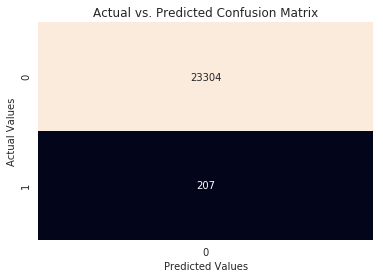

In [138]:
conf_mat = create_conf_mat(y_test,y_pred_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()


In [139]:
#Get predicted probabilites
target_probailities_log = rf.predict_proba(x_test)[:,1]

In [140]:
#Create true and false positive rates
log_false_positive_rate,log_true_positive_rate,log_threshold = roc_curve(y_test,target_probailities_log)


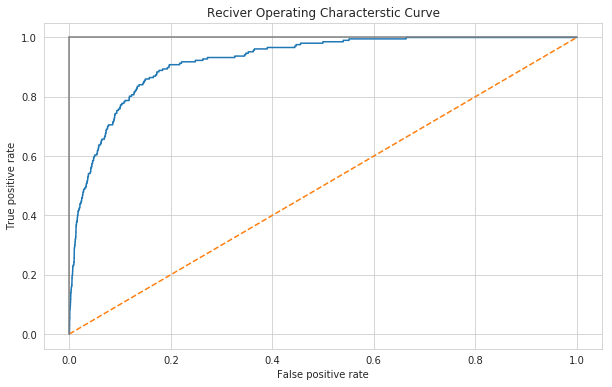

In [141]:
#Plot ROC Curve
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(log_false_positive_rate,log_true_positive_rate)
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [142]:
Model,ROC_AUC_Accuracy

(['Logistic Regression',
  'k-Nearest-Neighbours',
  'Naive Bayes',
  'Decision Tree',
  'Random Forest'],
 [0.5023940033930855, 0.5416240665283562, 0.6388319850545033, 0.5, 0.5])

# Now using the Bagging Classifiers

In [143]:
LR_Bag = BaggingClassifier(base_estimator=LR,n_estimators=100,n_jobs=-1,random_state=1)
knn_Bag = BaggingClassifier(base_estimator=knn,n_estimators=100,n_jobs=-1,random_state=1)
nb_Bag = BaggingClassifier(base_estimator=nb,n_estimators=100,n_jobs=-1,random_state=1)
dt_Bag = BaggingClassifier(base_estimator=dt,n_estimators=100,n_jobs=-1,random_state=1)

In [144]:
kf = KFold(n_splits=3,shuffle=True,random_state=1)
model = LR_Bag
name = 'Bagged-LR'
#for model,name in zip([LR_Bag,knn_Bag,nb_Bag,dt_Bag],['Bagged-LR','Bagged-kNN','Bagged-NB','Bagged-DT']):
roc_acc = []
for train,test in kf.split(x,y):
    x_train = x[train,:]
    x_test = x[test,:]
    y_train = y[train]
    y_test = y[test]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = roc_auc_score(y_test,y_pred)
    fpr,tpr,_ = roc_curve(y_test,y_pred)
    roc_acc.append(auc(fpr,tpr))
Model.append(name)
ROC_AUC_Accuracy.append(np.mean(roc_acc))
print('The AUC Score for')
print('%s is %0.02f with variacne of (+/-) %0.5f'%(name,np.mean(roc_acc),np.var(roc_acc,ddof=1)))

The AUC Score for
Bagged-LR is 0.51 with variacne of (+/-) 0.00001


In [145]:
kf = KFold(n_splits=5,shuffle=True,random_state=1)
model = nb_Bag
name = 'Bagged-NB'
#for model,name in zip([LR_Bag,knn_Bag,nb_Bag,dt_Bag],['Bagged-LR','Bagged-kNN','Bagged-NB','Bagged-DT']):
roc_acc = []
for train,test in kf.split(x,y):
    x_train = x[train,:]
    x_test = x[test,:]
    y_train = y[train]
    y_test = y[test]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = roc_auc_score(y_test,y_pred)
    fpr,tpr,_ = roc_curve(y_test,y_pred)
    roc_acc.append(auc(fpr,tpr))
Model.append(name)
ROC_AUC_Accuracy.append(np.mean(roc_acc))
print('The AUC Score for')
print('%s is %0.02f with variacne of (+/-) %0.5f'%(name,np.mean(roc_acc),np.var(roc_acc,ddof=1)))

The AUC Score for
Bagged-NB is 0.62 with variacne of (+/-) 0.00039


In [146]:
kf = KFold(n_splits=3,shuffle=True,random_state=1)
model = dt_Bag
name = 'Bagged-DT'
#for model,name in zip([LR_Bag,knn_Bag,nb_Bag,dt_Bag],['Bagged-LR','Bagged-kNN','Bagged-NB','Bagged-DT']):
roc_acc = []
for train,test in kf.split(x,y):
    x_train = x[train,:]
    x_test = x[test,:]
    y_train = y[train]
    y_test = y[test]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = roc_auc_score(y_test,y_pred)
    fpr,tpr,_ = roc_curve(y_test,y_pred)
    roc_acc.append(auc(fpr,tpr))
Model.append(name)
ROC_AUC_Accuracy.append(np.mean(roc_acc))
print('The AUC Score for')
print('%s is %0.02f with variacne of (+/-) %0.5f'%(name,np.mean(roc_acc),np.var(roc_acc,ddof=1)))

The AUC Score for
Bagged-DT is 0.50 with variacne of (+/-) 0.00000


## Now Moving Towards Boosting

In [147]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMModel,LGBMClassifier

In [148]:
LR_Boost = AdaBoostClassifier(base_estimator=LR,n_estimators=100,learning_rate=0.01,random_state=1)
knn_Boost = AdaBoostClassifier(base_estimator=knn,n_estimators=100,learning_rate=0.01,random_state=1)
nb_Boost = AdaBoostClassifier(base_estimator=nb,n_estimators=100,learning_rate=0.01,random_state=1)
dt_Boost = AdaBoostClassifier(base_estimator=dt,n_estimators=100,learning_rate=0.01,random_state=1)
rf_Boost = AdaBoostClassifier(base_estimator=rf,n_estimators=100,learning_rate=0.01,random_state=1)
gb_Boost = GradientBoostingClassifier(n_estimators=100,learning_rate=0.01)
lgbm = LGBMClassifier(objective='binary',n_estimators=100,reg_alpha=2,reg_lambda=5,random_state=1,learning_rate=0.01,is_unbalance=True)

In [149]:
kf = KFold(n_splits=5,shuffle=True,random_state=1)
model = LR_Boost
name = 'Boosted-LR'
#for model,name in zip([LR_Boost,nb_Boost,dt_Boost,rf_Boost,lgbm],['Boosted-LR','Boosted-NB','Boosted-DT','Boosted - Random Forest','LGBM']):
roc_acc = []
for train,test in kf.split(x,y):
    x_train = x[train,:]
    x_test = x[test,:]
    y_train = y[train]
    y_test = y[test]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = roc_auc_score(y_test,y_pred)
    fpr,tpr,_ = roc_curve(y_test,y_pred)
    roc_acc.append(auc(fpr,tpr))
Model.append(name)
ROC_AUC_Accuracy.append(np.mean(roc_acc))
print('The AUC Score for')
print('%s is %0.02f with variacne of (+/-) %0.5f'%(name,np.mean(roc_acc),np.var(roc_acc,ddof=1)))

The AUC Score for
Boosted-LR is 0.50 with variacne of (+/-) 0.00000


In [150]:
kf = KFold(n_splits=5,shuffle=True,random_state=1)
model = nb_Boost
name = 'Boosted-NB'
#for model,name in zip([LR_Boost,nb_Boost,dt_Boost,rf_Boost,lgbm],['Boosted-LR','Boosted-NB','Boosted-DT','Boosted - Random Forest','LGBM']):
roc_acc = []
for train,test in kf.split(x,y):
    x_train = x[train,:]
    x_test = x[test,:]
    y_train = y[train]
    y_test = y[test]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = roc_auc_score(y_test,y_pred)
    fpr,tpr,_ = roc_curve(y_test,y_pred)
    roc_acc.append(auc(fpr,tpr))
Model.append(name)
ROC_AUC_Accuracy.append(np.mean(roc_acc))
print('The AUC Score for')
print('%s is %0.02f with variacne of (+/-) %0.5f'%(name,np.mean(roc_acc),np.var(roc_acc,ddof=1)))

The AUC Score for
Boosted-NB is 0.57 with variacne of (+/-) 0.00013


In [151]:
kf = KFold(n_splits=5,shuffle=True,random_state=1)
model = dt_Boost
name = 'Boosted-DT'
#for model,name in zip([LR_Boost,nb_Boost,dt_Boost,rf_Boost,lgbm],['Boosted-LR','Boosted-NB','Boosted-DT','Boosted - Random Forest','LGBM']):
roc_acc = []
for train,test in kf.split(x,y):
    x_train = x[train,:]
    x_test = x[test,:]
    y_train = y[train]
    y_test = y[test]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = roc_auc_score(y_test,y_pred)
    fpr,tpr,_ = roc_curve(y_test,y_pred)
    roc_acc.append(auc(fpr,tpr))
Model.append(name)
ROC_AUC_Accuracy.append(np.mean(roc_acc))
print('The AUC Score for')
print('%s is %0.02f with variacne of (+/-) %0.5f'%(name,np.mean(roc_acc),np.var(roc_acc,ddof=1)))

The AUC Score for
Boosted-DT is 0.50 with variacne of (+/-) 0.00000


In [152]:
kf = KFold(n_splits=5,shuffle=True,random_state=1)
model = lgbm
name = 'LGBM'
#for model,name in zip([LR_Boost,nb_Boost,dt_Boost,rf_Boost,lgbm],['Boosted-LR','Boosted-NB','Boosted-DT','Boosted - Random Forest','LGBM']):
roc_acc = []
for train,test in kf.split(x,y):
    x_train = x[train,:]
    x_test = x[test,:]
    y_train = y[train]
    y_test = y[test]
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = roc_auc_score(y_test,y_pred)
    fpr,tpr,_ = roc_curve(y_test,y_pred)
    roc_acc.append(auc(fpr,tpr))
Model.append(name)
ROC_AUC_Accuracy.append(np.mean(roc_acc))
print('The AUC Score for')
print('%s is %0.02f with variacne of (+/-) %0.5f'%(name,np.mean(roc_acc),np.var(roc_acc,ddof=1)))

The AUC Score for
LGBM is 0.79 with variacne of (+/-) 0.00048


In [153]:
Model,ROC_AUC_Accuracy

(['Logistic Regression',
  'k-Nearest-Neighbours',
  'Naive Bayes',
  'Decision Tree',
  'Random Forest',
  'Bagged-LR',
  'Bagged-NB',
  'Bagged-DT',
  'Boosted-LR',
  'Boosted-NB',
  'Boosted-DT',
  'LGBM'],
 [0.5023940033930855,
  0.5416240665283562,
  0.6388319850545033,
  0.5,
  0.5,
  0.5117292736427547,
  0.6230308812767824,
  0.5,
  0.49999356664951106,
  0.56672680424923,
  0.5,
  0.7918219073058774])

In [154]:
final_result = pd.DataFrame({'Model':Model,'Accuracy':ROC_AUC_Accuracy})
final_result

,Model,Accuracy
0,Logistic Regression,0.502394
1,k-Nearest-Neighbours,0.541624
2,Naive Bayes,0.638832
3,Decision Tree,0.500000
4,Random Forest,0.500000
5,Bagged-LR,0.511729
6,Bagged-NB,0.623031
7,Bagged-DT,0.500000
8,Boosted-LR,0.499994
9,Boosted-NB,0.566727
